# Exploring automatic differentiation in quantitative finance

Concatenation and research extension by Glen HIGH

## Introduction

In computational finance, finding prices is only a fraction of the game. The most calculation-costly step is to get all partial derivatives, the so-called greeks. Indeed, an increasivelly heavy regulatory framework regarding those greeks lead to a spike of interrest in new numerical methods by market practitionners. Under BCBS's Minimum capital requirements for market risk, an investment bank is supposed to be able to compute many sensitivities to be plugged into the capital requirement formula. For instance, [2, Section B.2.iii.] demands to compute delta, vega and curvature for “each financial product with optionality” owned by a bank. These sensitivities are partial derivatives of the value of the instrument with respect to different risk factors, grouped into risk classes. Seven risk classes are defined. As an example, the risk factors of the General Interest Rate Risk class are [2, pp20-22] :

- for the delta: “delta risk factors are defined along two dimensions: a risk-free yield curve for each currency in which interest rate-sensitive instruments are denominated and” ten maturities.
- For the vega: “within each currency, the vega risk factors are the implied volatilities of options that reference general interest rate risk-sensitive underlyings; further defined along two dimensions: Residual maturity of the underlying of the option at the expiry date of the option and the Residual maturity of the underlying of the option at the expiry date of the option.” Each of them over 5 maturities.

We just listed more than 30 sensitivities to compute, belonging to one of the seven risk classes, to be applied on each financial instrument owned by the bank. Each sensitivity is a partial derivative. Algorithmic automatic differentiation is a legitimate answer to this need.


## 1 Review of different methodologies

| Methodology | Efficiency | Precision |
| :----------- | :----------- | :----------- |
| Finite difference | Finite difference requires several amounts of pricing function calls (2 for 1st order, 3 for 2nd, ...) for which many computation steps are identical, let's not even talk about the monte-carlo pricing case | Finite difference method is firstly an approximator that is also prone to computer precision error when dealing with smal values of h |
| Hard-coded derivatives | Evaluation of hard-coded derivative functions may relie on many values that have already been computed while first getting the price | Hard-coded derivatives has exact precision |

Can't we keep the best of the two worlds? I.e. a mathematically precise derivative capitalizing on stored intermediate values and pre-coded elementary derivation formulas...


## 2 Automatic differentiation

Automatic differentiation exploits the fact that every computer calculation, no matter how complicated, executes a sequence of elementary arithmetic operations (addition, subtraction, multiplication, division, etc.) and elementary functions (exp, log, sin, cos, etc.). By applying the chain rule repeatedly to these operations, partial derivatives of arbitrary order can be computed automatically, accurately to working precision, and using at most a small constant factor of more arithmetic operations than the original program.

### Forward mode

In forward accumulation AD, one first fixes the independent variable with respect to which differentiation is performed and computes the derivative of each sub-expression recursively. In a pen-and-paper calculation, this involves repeatedly substituting the derivative of the inner functions in the chain rule:

![image.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/cb8633d881482245a77285d008ac3a902276c73c)

In the following example is shown forward computation of the partial values with respect to inputs for the function :
$$ f(x_1,x_2) = {sin(x_1) + x_2 \times x_1 } $$

![image.png](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/ForwardAccumulationAutomaticDifferentiation.png/450px-ForwardAccumulationAutomaticDifferentiation.png)

### Reverse (or adjoint) mode

In reverse accumulation AD, the dependent variable to be differentiated is fixed and the derivative is computed with respect to each sub-expression recursively. In a pen-and-paper calculation, the derivative of the outer functions is repeatedly substituted in the chain rule:

![image.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/16bec7d55f27946c3dbe4e1e8eee9e390b31b7c9)

In the following example is shown forward computation of the partial values with respect to inputs for the same function :
$$ f(x_1,x_2) = {sin(x_1) + x_2 \times x_1 } $$

![image.png](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/ReverseaccumulationAD.png/450px-ReverseaccumulationAD.png)


### Reverse mode : practical use in finance and adapted differentiation scales

#### a) A practical example

As seen above, AAD is a matter of multiple derivations with respect to all variables, similar to the computation of a Jacobian matrix. The fact is that differentiation can be dealt with at several scales. This is a critical point for scalability of an AAD framework. Consider the following practical example for the absurdly anoying function f:

$$ f(a,b,c)=(ln( e^{(sin(ab)+cb^2+a^3c^2)^2-1}+a^2)^2+1+cos(c^2-1)-d)^2 $$ 

Here, we will want to get by reverse AAD the partial derivatives of f with respect to a,b and c (d being a constant).
Let us rewrite f as:

$$ \begin{aligned}f(a,b,c)&=(w-d)^2 
\\ w&=ln(v^2+1)+cos(c^2-1) 
\\ v&=e^{(u)^2-1}+a^2 
\\ u&=sin(ab)+cb^2+a^3c^2 \end{aligned}$$ 

In that case, it is possible to write the adjoint deriving at the scale of intermediate variables u, v and w. To get those statements, we need to write the adjoints in reverse order:

$$\begin{aligned} &\bar{w}=2(w-d)\bar{f}
\\ &\bar{c}=-2csin(c^2-1)\bar{w}
\\ &\bar{v}={2v \over {v^2+1}}\bar{w} 
\\ &\bar{a}=2a\bar{v} 
\\ &\bar{u}=2ue^{u^2-1}\bar{v} 
\\ &\begin{bmatrix}\bar{a} \\ \bar{b} \\ \bar{c}\end{bmatrix} = \begin{bmatrix}1 & 0 & 0 & bcos(ab)+3a^2c^2 \\ 0 & 1 & 0 & acos(ab)+2cb \\ 0 & 0 & 1 & b2+2a^3c \end{bmatrix}\begin{bmatrix}\bar{a} \\ \bar{b} \\ \bar{c} \\ \bar{u} \end{bmatrix} \end{aligned}$$

We can then rephrase our adjoint chain as follows:
$$ \begin{aligned}\bar{w}&=2(w-d)\bar{f}
\\ \bar{c}&=-2csin(c^2-1)\bar{w}
\\ \bar{v}&={2v \over {v^2+1}}\bar{w}
\\ \bar{a}&=2a\bar{v}  
\\ \bar{u}&=2ue^{u^2-1}\bar{v}
\\ \frac{\partial f}{\partial a} = \bar{a}&=\bar{a}+(bcos(ab)+3a^2c^2)\bar{u}
\\ \frac{\partial f}{\partial b}=\bar{b}&=\bar{b}+(acos(ab)+2cb)\bar{u}
\\ \frac{\partial f}{\partial c} =\bar{c}&=\bar{c}+(b^2+2a^3)c\bar{u}
\end{aligned}$$ 

To get our derivatives w.r.t a,b and c all we have to do is: 
- compute forward to get w, v and u
- initialize $(\bar{a}, \bar{b}, \bar{c})=(1,1,1)$ 
- plug values of $(u,v,w)$,$(a,b,c)$ and $(\bar{a}, \bar{b}, \bar{c})$ in the reverse chain we built

#### b) An application in finance

A practical example is given by David Dallaire (https://github.com/dallaire44/ipython/blob/master/Monte%20Carlo%20Option%20Greeks%20by%20Hand%20Made%20Adjoint%20of%20Automatic%20Differentiation.ipynb) in which he computes adjoints for a Monte-Carlo options pricer at the scale of the discretized path :

$$ \begin{aligned} S_{n+1} &= S_n + rS_n \Delta_t +  \sigma S_n \sqrt{ \Delta_t}Z_n \; n = 0,...N-1
\\ \Rightarrow  \bar{S}_n &= (1 + r\Delta_t + \sigma \sqrt{\Delta_t}Z_n)\bar{S}_{n+1} \end{aligned}$$
Here again, for each path the adjoint has to do a forward pass: it steps through time going forward to the payoff. Some of the path parameters needed on the backward pass can be stored during this forward pass. For example, each $S_n$ and random numbers $Z_n$ of the path are stored. This works fine but requires to do the maths then code the adjoint equations for every new payoff or any change/improvement made in the engine (local volatility, Heston model, ...).


#### c) The ideal path: an AAD engine
With automatic differentiation, you have not to develop a dedicated code each time you have a new product on which you need to compute sensitivities. It is “enough” to embed your overall numerical libraries in a framework supporting AAD.

Barak A. Pearlmutter classified four types of AAD implementation scales:
- I : A calculus for efficiently calculating derivatives of functions specified by a set of equations
- II : Rules applied manually which mechanically transform a computer program implementing a numeric function to also efficiently calculate some derivatives
- III : A computer program which automatically transforms an input computer program specifying a numeric function into one that also efficiently calculates derivatives
- IV : AD-taking operators included in language in which numeric algorithms are written, and they can be applied to procedure which use them

Frameworks presented in a) and b) belong to type II. The basic idea of type IV is that we already teach at school the well feared tables of basic functions' derivatives. So why not teach them also to machines so they can efficiently figure out the right adjoints to use whithout quants to manually derive functions?

## 3 Implementing a type IV AAD framework

To build a functioning type IV reverse AAD framework in python we will rely on the basic following libraries: 

In [2]:
import math
from scipy.stats import norm
import time
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

In this project, every equation (any pricing function such as closed-formula Black-Scholes or even Monte-Carlo approaches as in section 2.b) of this notebook) will be considered as a numerical expression calling basic operators recognized by the machine. The idea behind this framework is to overload each elementary operator (elementary functions as well, they'll be treated as operators here) as itself AND its adjoint value based on derivative(s) of the operator with respect to input(s). 

Each intermediate value resulting from the application of an operator to inputs will be stored as a dual number: the result and its adjoint computed based on the derivative library we'll code. For the reason detailed in 2.a and 2.b, we will need a forward pass followed by a backward computation of adjoint values. The program reasoning at the scale of an operator, the time when all the required values to compute an adjoint are available (inputs (that can be intermediate forward values) and possibly other prior adjoints) is not know in advance. The framework thus has to be coded in a recursive fashion.

### a) The setup

A first class Variable is implemented. It will be used by our program to recognize and store floating-point variables :

In [3]:
class Expression:
    def __add__(self, other):
        return Plus(self, other)
    def __sub__(self, other):
        return Minus(self, other)
    def __mul__(self, other):
        return Multiply(self, other)
    def __truediv__(self, other):
        return Divise(self, other)

class Variable(Expression):
    def __init__(self, value):
        self.value = value
        self.partial = 0

    def evaluate(self):
        pass

    def derive(self, seed):
        self.partial += seed

Its value is stored, its partial is zero (assuming derived w.r.t itself), it does not have an evaluation method (we'll see this when adding operators to the mix) and when derived it simply passes on the adjoint value carried up to itself (since its partial is zero). It relies on the class Expression that handles basic arithmetics overloading native python operators (__add__() becomes our hand-coded Plus() operator). 

Talking about Plus(), let's code it:

In [4]:
class Plus(Expression):
    def __init__(self, expressionA, expressionB):
        self.expressionA = expressionA
        self.expressionB = expressionB
        self.value = None

    def evaluate(self):
        self.expressionA.evaluate()
        self.expressionB.evaluate()
        self.value = self.expressionA.value + self.expressionB.value

    def derive(self, seed):
        self.expressionA.derive(seed)
        self.expressionB.derive(seed)

It's a class having to inputs A and B. Values are stored when first-instanciated. Evaluate method simply stores the value of the corrisponding operator +. Derive function just passes-on the seed since derivative of A+B (wrt A or B) gives 1. To make this seed-passing clearer, let's code the operator Multiply that does not have a netral impact on seed:

In [5]:
class Multiply(Expression):
    def __init__(self, expressionA, expressionB):
        self.expressionA = expressionA
        self.expressionB = expressionB
        self.value = None

    def evaluate(self):
        self.expressionA.evaluate()
        self.expressionB.evaluate()
        self.value = self.expressionA.value * self.expressionB.value

    def derive(self, seed):
        self.expressionA.derive(self.expressionB.value * seed)
        self.expressionB.derive(self.expressionA.value * seed)


Here, evaluate() changes as it stores the value of the \* operator. Also, derive() method changes. Consider the function $f(a,b)=36*a*b$. As seen in part 2 of this notebook, once the forward pass is dealt with, the seed is initiated to 1 to compute adjoints backwards. 

The code will process this function in two steps: first focusing on the operation $36*right$ (for which $\frac{\partial (36*right)}{\partial right} =36$, then on $a*b$ according to the seed-passing rule we set for \*. 

Here, $\frac{\partial (a*b)}{\partial a} = b$ and $\frac{\partial (a*b)}{\partial b} =a$ so the legacy adjoint (seed) being 36, the derivative $\frac{\partial f}{\partial a} = b*seed=b*36$.

Let's now add the classes for every operator we will need (including exponential, logarithm or even normal cumulative density function operators).

In [6]:
class Sinus(Expression):
    def __init__(self, expressionA):
        self.expressionA = expressionA
        self.value = None

    def evaluate(self):
        self.expressionA.evaluate()
        self.value = math.sin(self.expressionA.value)

    def derive(self, seed):
        self.expressionA.derive(math.cos(self.expressionA.value)*seed)

class Plus(Expression):
    def __init__(self, expressionA, expressionB):
        self.expressionA = expressionA
        self.expressionB = expressionB
        self.value = None

    def evaluate(self):
        self.expressionA.evaluate()
        self.expressionB.evaluate()
        self.value = self.expressionA.value + self.expressionB.value

    def derive(self, seed):
        self.expressionA.derive(seed)
        self.expressionB.derive(seed)
        
class Minus(Expression):
    def __init__(self, expressionA, expressionB):
        self.expressionA = expressionA
        self.expressionB = expressionB
        self.value = None

    def evaluate(self):
        self.expressionA.evaluate()
        self.expressionB.evaluate()
        self.value = self.expressionA.value - self.expressionB.value

    def derive(self, seed):
        self.expressionA.derive(seed)
        self.expressionB.derive(-seed)

class Multiply(Expression):
    def __init__(self, expressionA, expressionB):
        self.expressionA = expressionA
        self.expressionB = expressionB
        self.value = None

    def evaluate(self):
        self.expressionA.evaluate()
        self.expressionB.evaluate()
        self.value = self.expressionA.value * self.expressionB.value

    def derive(self, seed):
        self.expressionA.derive(self.expressionB.value * seed)
        self.expressionB.derive(self.expressionA.value * seed)

class Divise(Expression):
    def __init__(self, expressionA, expressionB):
        self.expressionA = expressionA
        self.expressionB = expressionB
        self.value = None

    def evaluate(self):
        self.expressionA.evaluate()
        self.expressionB.evaluate()
        self.value = self.expressionA.value / self.expressionB.value

    def derive(self, seed):
        self.expressionA.derive(seed/self.expressionB.value)
        self.expressionB.derive(-self.expressionA.value * seed/self.expressionB.value**2)

class Exponent(Expression):
    def __init__(self, expressionA):
        self.expressionA = expressionA
        self.value = None

    def evaluate(self):
        self.expressionA.evaluate()
        self.value = math.exp(self.expressionA.value)

    def derive(self, seed):
        self.expressionA.derive(math.exp(self.expressionA.value)*seed)
        
class Logarithm(Expression):
    def __init__(self, expressionA):
        self.expressionA = expressionA
        self.value = None

    def evaluate(self):
        self.expressionA.evaluate()
        self.value = math.log(self.expressionA.value)

    def derive(self, seed):
        self.expressionA.derive(seed/self.expressionA.value)
        
        
class NormCDF(Expression):
    def __init__(self, expressionA):
        self.expressionA = expressionA
        self.value = None

    def evaluate(self):
        self.expressionA.evaluate()
        self.value = norm.cdf(self.expressionA.value)

    def derive(self, seed):
        self.expressionA.derive(math.exp(-0.5*self.expressionA.value**2)*seed/math.sqrt(2*math.pi))

class Square(Expression):
    def __init__(self, expressionA):
        self.expressionA = expressionA
        self.value = None

    def evaluate(self):
        self.expressionA.evaluate()
        self.value = self.expressionA.value**2

    def derive(self, seed):
        self.expressionA.derive(2*seed*self.expressionA.value)
         
class Root(Expression):
    def __init__(self, expressionA):
        self.expressionA = expressionA
        self.value = None

    def evaluate(self):
        self.expressionA.evaluate()
        self.value = self.expressionA.value**0.5

    def derive(self, seed):
        self.expressionA.derive(seed/(2*self.expressionA.value))


### b) Using the library for Black-Scholes prices 

We can now price and get greeks for those payoffs by coding an expression representing Black-Scholes equation using our library of operators:

In [11]:
#Initialise required parameters as variables:
S =Variable(107)
K=Variable(100)
T=Variable(2)
sigma=Variable(0.23)
r=Variable(0.02)

#insert into Black-Scholes components using our functions:
d1= (Logarithm(S/K)+(r+Variable(0.5)*Square(sigma)))/(sigma*Root(T))
d2=d1-sigma*Root(T)
Call= NormCDF(d1)*S-NormCDF(d2)*K*Exponent(Variable(0)-r*T)

#evaluate expression, then derive backwards with seed = 1:
Call.evaluate()
Call.derive(1)

#print partials (remembering that T is time to maturity hence - sign)
AAD_values = ["Reverse mode AAD", Call.value, S.partial, K.partial, -T.partial, sigma.partial, r.partial]
recap = pd.DataFrame([["Type","Call price", "∂C/∂S =", "∂C/∂K =","∂C/∂T =","∂C/∂sigma =","∂C/∂r ="],
     AAD_values])
                      
print(recap)                


                  0           1         2         3        4            5  \
0              Type  Call price   ∂C/∂S =   ∂C/∂K =  ∂C/∂T =  ∂C/∂sigma =   
1  Reverse mode AAD     19.1551  0.689481 -0.546195 -3.07064      52.6985   

         6  
0  ∂C/∂r =  
1  103.638  


For the sake of simplicity, let's code wrappers to embed BS formulas for calls, digitals and up-and-in options into expressions digestable by our framework:

In [12]:
def call_expression(S,K,T,sigma,r):
    d1= (Logarithm(S/K)+(r+Variable(0.5)*Square(sigma))*T)/(sigma*Root(T))
    d2=d1-sigma*Root(T)
    return NormCDF(d1)*S-NormCDF(d2)*K*Exponent(Variable(0)-r*T)

def digital_call(S,K,T,sigma,r):
    d2= (Logarithm(S/K)+(r-Variable(0.5)*Square(sigma))*T)/(sigma*Root(T))
    return NormCDF(d2)*Exponent(Variable(0)-r*T)

def call_upin_barrier_expression(S,K,T,sigma,r,B):# = call(S,B) + (B-K)*Digit(S,B)
    d1= (Logarithm(S/B)+(r+Variable(0.5)*Square(sigma))*T)/(sigma*Root(T))#B in d1 because Call(S,B)
    d2=d1-sigma*Root(T)
    return NormCDF(d1)*S-NormCDF(d2)*K*Exponent(Variable(0)-r*T)#K here from the simplification of above equation in comment
  

The previous section then becomes:

In [15]:
#with previous values
Call=call_expression(S,K,T,sigma,r)

#evaluate expression, then derive backwards with seed = 1:
Call.evaluate()
Call.derive(1)

#print partials (remembering that T is time to maturity hence - sign)
AAD_values = ["Reverse mode AAD", Call.value, S.partial, K.partial, -T.partial, sigma.partial, r.partial]
recap = pd.DataFrame([["Type","Call price", "∂C/∂S =", "∂C/∂K =","∂C/∂T =","∂C/∂sigma =","∂C/∂r ="],
     AAD_values])
print(recap)

                  0           1        2        3        4            5  \
0              Type  Call price  ∂C/∂S =  ∂C/∂K =  ∂C/∂T =  ∂C/∂sigma =   
1  Reverse mode AAD     19.2838  2.75712 -2.18005 -12.8572      213.031   

         6  
0  ∂C/∂r =  
1  430.409  


### c) Comparing BS AAD with finite difference BS

Now to illustrate the time gained by AAD framework when compared to classical BS implementation with central finite difference sensitivities, let's compute 1k times each and compare runtimes:

In [17]:
   
def MAIN_compare_AAD_CDS():
    ###################################
    # 1 BS WITH REVERSE AUTODIFF
    
    start_time = time.time()
    
    for i in range(1000):
        S =Variable(107)
        K=Variable(100)
        T=Variable(2)
        sigma=Variable(0.23)
        r=Variable(0.02)
        B=Variable(110)
        
        Call=call_expression(S,K,T,sigma,r)
        Call.evaluate()
        Call.derive(1)
    
    t_AAD=time.time() - start_time
    print("Elapsed autodiff: ", t_AAD)
    
    AAD_values = ["Reverse mode AAD", Call.value, S.partial, K.partial, -T.partial, sigma.partial, r.partial]
    
    ##################################"
    # 2 BS WITH CENTRAL DIFF SCHEME
    
    
    def BSCall(S,K,T,sigma,r):
        d1=(math.log(S/K)+(r+0.5*sigma**2))/(sigma*math.sqrt(T))
        d2=d1-sigma*math.sqrt(T)
        return norm.cdf(d1)*S-norm.cdf(d2)*K*math.exp(-r*T)
    
    start_time = time.time()
    
    for i in range(1000):
        S=107
        K=100
        T=2
        sigma=0.23
        r=0.02
        
        h=0.00001
        
        Call=BSCall(S,K,T,sigma,r)
        delta=(BSCall(S+h,K,T,sigma,r)-BSCall(S-h,K,T,sigma,r))/(2*h)
        kappa=(BSCall(S,K+h,T,sigma,r)-BSCall(S,K-h,T,sigma,r))/(2*h)
        theta=-(BSCall(S,K,T+h,sigma,r)-BSCall(S,K,T-h,sigma,r))/(2*h)
        vega=(BSCall(S,K,T,sigma+h,r)-BSCall(S,K,T,sigma-h,r))/(2*h)
        rho=(BSCall(S,K,T,sigma,r+h)-BSCall(S,K,T,sigma,r-h))/(2*h)
    
    t_CDS=time.time() - start_time
    
    print("Elapsed central diff scheme: ", (t_CDS))
    
    print("AAD only takes ",round(100.0*t_AAD/t_CDS,1),"% of central diff scheme")
    
    BS_values = ["Central diff. scheme", Call, delta,kappa, theta, vega,rho]
    
    recap= pd.DataFrame([["Type","Call price", "∂C/∂S =", "∂C/∂K =","∂C/∂T =","∂C/∂sigma =","∂C/∂r ="],
     AAD_values,
     BS_values])
    
    print(recap)

MAIN_compare_AAD_CDS()

Elapsed autodiff:  0.5470016002655029
Elapsed central diff scheme:  3.5614748001098633
AAD only takes  15.4 % of central diff scheme
                      0           1         2         3        4            5  \
0                  Type  Call price   ∂C/∂S =   ∂C/∂K =  ∂C/∂T =  ∂C/∂sigma =   
1      Reverse mode AAD     19.2838  0.689212 -0.544619  -3.2622       53.444   
2  Central diff. scheme     19.1551  0.689481 -0.546195 -3.93646      52.6985   

         6  
0  ∂C/∂r =  
1  108.924  
2  103.638  


The log reads :

Elapsed autodiff:  0.5470016002655029
Elapsed central diff scheme:  3.5614748001098633
AAD only takes  15.4 % of central diff scheme

### d) Comparing BS AAD with closed-form greeks

Now we could also compare our framework to a supposedly faster closed-formula implemented BS greeks:

In [18]:
def MAIN_compare_AAD_CFG():
    ###################################
    # 1 BS WITH REVERSE AUTODIFF
    
    start_time = time.time()
    
    for i in range(1000):
        S =Variable(107)
        K=Variable(100)
        T=Variable(2)
        sigma=Variable(0.23)
        r=Variable(0.02)
        
        
        d1= (Logarithm(S/K)+(r+Variable(0.5)*Square(sigma)))/(sigma*Root(T))
        d2=d1-sigma*Root(T)
        Call= NormCDF(d1)*S-NormCDF(d2)*K*Exponent(Variable(0)-r*T)
        Call.evaluate()
        Call.derive(1)
    
    t_AAD=time.time() - start_time
    print("Elapsed autodiff: ", t_AAD)
    
    AAD_values = ["Reverse mode AAD", Call.value, S.partial, K.partial, -T.partial, sigma.partial, r.partial]
    del S,K,T,sigma,r
    ##################################"
    # 2 BS WITH CLOSED FORM GREEKS
    
    
    def BSCall(S,K,T,sigma,r):
        d1=(math.log(S/K)+(r+0.5*sigma**2))/(sigma*math.sqrt(T))
        d2=d1-sigma*math.sqrt(T)
        return norm.cdf(d1)*S-norm.cdf(d2)*K*math.exp(-r*T)
    
    def BSDelta(S,K,T,sigma,r):
        d1=(math.log(S/K)+(r+0.5*sigma**2))/(sigma*math.sqrt(T))
        return norm.cdf(d1)
    
    def BSKappa(S,K,T,sigma,r):
        d1=(math.log(S/K)+(r+0.5*sigma**2))/(sigma*math.sqrt(T))
        d2=d1-sigma*math.sqrt(T)
        return -norm.cdf(d2)*math.exp(-r*T)
    
    def BSVega(S,K,T,sigma,r):
        d1=(math.log(S/K)+(r+0.5*sigma**2))/(sigma*math.sqrt(T))
        return norm.pdf(d1)*S*math.sqrt(T)
    
    def BSTheta(S,K,T,sigma,r):
        d1=(math.log(S/K)+(r+0.5*sigma**2))/(sigma*math.sqrt(T))
        d2=d1-sigma*math.sqrt(T)
        return norm.pdf(d1)*S*sigma/(2*math.sqrt(T))+r*K*math.exp(-r*T)*norm.cdf(d2)
    
    def BSRho(S,K,T,sigma,r):
        d1=(math.log(S/K)+(r+0.5*sigma**2))/(sigma*math.sqrt(T))
        d2=d1-sigma*math.sqrt(T)
        return norm.cdf(d2)*math.exp(-r*T)*K*T
    
    start_time = time.time()
    
    for i in range(1000):
        S=107
        K=100
        T=2
        sigma=0.23
        r=0.02
        
        Call=BSCall(S,K,T,sigma,r)
        delta=BSDelta(S,K,T,sigma,r)
        kappa=BSKappa(S,K,T,sigma,r)
        theta=BSTheta(S,K,T,sigma,r)
        vega=BSVega(S,K,T,sigma,r)
        rho=BSRho(S,K,T,sigma,r)
    
    t_CDS=time.time() - start_time
    
    print("Elapsed closed-form greeks: ", (t_CDS))
    
    print("AAD only takes ",round(100.0*t_AAD/t_CDS,1),"% of central diff scheme")
    
    BS_values = ["Closed-form", Call, delta,kappa, theta, vega,rho]
    
    recap= pd.DataFrame([["Type","Call price", "∂C/∂S =", "∂C/∂K =","∂C/∂T =","∂C/∂sigma =","∂C/∂r ="],
     AAD_values,
     BS_values])
    
    print(recap)

MAIN_compare_AAD_CFG()

Elapsed autodiff:  0.4759969711303711
Elapsed closed-form greeks:  1.2959976196289062
AAD only takes  36.7 % of central diff scheme
                  0           1         2         3        4            5  \
0              Type  Call price   ∂C/∂S =   ∂C/∂K =  ∂C/∂T =  ∂C/∂sigma =   
1  Reverse mode AAD     19.1551  0.689481 -0.546195 -3.07064      52.6985   
2       Closed-form     19.1551  0.637136 -0.490185  4.24439      56.7655   

         6  
0  ∂C/∂r =  
1  103.638  
2  98.0369  


The log reads :

Elapsed autodiff:  0.4759969711303711
Elapsed closed-form greeks:  1.2959976196289062
AAD only takes  36.7 % of central diff scheme

AAD is still faster, and does not require to implement formulas for greeks. 

### e) Implementing an MC ADD framework

Now for fun, let's try to build a MC engine to evaluate via AAD any european payoff, provided its adjoint terminal payoff is coded into our library.

Starting with call and DIP options:

In [19]:

class EuroCall(Expression):
    def __init__(self, expressionA, expressionB):
        self.expressionA = expressionA
        self.expressionB = expressionB
        self.value = None

    def evaluate(self):
        self.expressionA.evaluate()#S_T
        self.expressionB.evaluate()#K
        self.value = max(self.expressionA.value-self.expressionB.value,0)#max(S_T-K,0)


    def derive(self, seed):
        deriveA_value=0.0
        deriveB_value=-1.0
        if self.expressionA.value>self.expressionB.value:
            deriveA_value=1.0
            deriveB_value=0.0
        self.expressionA.derive(seed*deriveA_value)
        self.expressionB.derive(seed*deriveB_value)
        
class EuroDIP(Expression):
    def __init__(self, expressionA, expressionB,expressionC):
        self.expressionA = expressionA
        self.expressionB = expressionB
        self.expressionC = expressionC
        self.value = None

    def evaluate(self):
        self.expressionA.evaluate()#S_T
        self.expressionB.evaluate()#K
        self.expressionC.evaluate()#Barrier
        ret=0
        if self.expressionA.value<self.expressionC.value:
            ret=max(self.expressionB.value-self.expressionA.value,0)
        self.value =ret 

    def derive(self, seed):
        deriveA_value=0.0
        deriveB_value=0.0
        deriveC_value= 0.0
        if self.expressionA.value<self.expressionC.value:
            deriveA_value=-1.0
            deriveB_value=1.0
        self.expressionA.derive(seed*deriveA_value)
        self.expressionB.derive(seed*deriveB_value)
        self.expressionC.derive(seed*deriveC_value)


The next thing we'll need is a white-noise generating function :

In [20]:
#1 : Basic MC engine

def paths(num, periods):
    temp= np.random.normal(0, 1, size=(num,periods))
    ret=[]
    
    for i in range(np.size(temp,0)):
        row=[]
        for j in range(np.size(temp,1)):
            row.append(Variable(temp[i,j]))
        ret.append(row)
    return ret

Now, for this one I got creative. Ideally, an MC framework is basically a loop computing terminal value of a given payoff knowing a given path, then those final prices are meaned and discounted. The fact is that I have yet to figure out how to add a for loop and compute adjoints to my library (please keep in mind that I develop all this at the sacrifice of coffee breaks at work).

So the "simplest" idea that sprung to my mind was to create a function that concatenates within a string the expression to be evaluated:

Say I want a MC price based on 2 simulations, i'll have this function create the string

"(call_expression(S[0],K,T,sigma,r) + call_expression(S[1],K,T,sigma,r))/2"

adding each call_expressing into a loop, then dicounting the evaluated string.

Fisrt let's build a function storing into a string the code to evaluate n times the output of our paths function as a geometric brownian motion:

**Warning, executing string-based code can be dangerous and can permanently corrupt your computer, please do not execute the following if you are not familiar with the underlying concepts**

In [21]:
def GBM_terminal_value_string(mypaths):
#==============================================================================
#     WARNING : mypaths must be the name of the variable holding paths generated by paths() function
#==============================================================================
    ret=[]
    for i in range(len(mypaths)):
        tempstr =""
        for j in range(len(mypaths[0])):
            tempstr = f'S*Exponent((r-Variable(0.5)*Square(sigma))*T+sigma*Root(T)*mypaths[{i}][{j}])'
        ret.append(tempstr)
    return ret

Then, add the function to evaluate payoff wrt GBM terminal value:

In [23]:
def evaluate_mean_of_eurocall_for_paths(GBM_string_array):
    ret=""#will be the sum of all terminal GBM evaluated by EuroCall operator
    for i in range(len(GBM_string_array)):
        ret+=f'EuroCall(eval(GBM_string_array[{i}]),K)+'
    ret=ret[:-1]#trim last + added in the loop
    return "Exponent(Variable(0)-r*T)*("+ret+")/n_simul"#Var(0) because - operator is binary (won't work without any variable before)

def evaluate_mean_of_custom_euro_payoff_for_paths(GBM_string_array,payoff_name):
    ret=""#will be the sum of all terminal GBM evaluated by EuroCall operator
    for i in range(len(GBM_string_array)):
        ret+= payoff_name+ f'(eval(GBM_string_array[{i}]),K,B)+'
    ret=ret[:-1]#trim last + added in the loop
    return "Exponent(Variable(0)-r*T)*("+ret+")/n_simul"#Var(0) because - operator is binary (won't work without any variable before)
    

We can now evaluate the resulting string using python's **eval** function (at your own risk) into our framework: 

In [24]:
def MAIN_MC_EuroCall_study():
    
    sys.setrecursionlimit(99999)
    start_time = time.time()
    S =Variable(107)
    K=Variable(100)
    T=Variable(2)
    sigma=Variable(0.23)
    r=Variable(0.02)
    
    n_simul=Variable(2000)
    n_simul_int=n_simul.value
    
    mypaths = paths(n_simul_int,1)
    GBM_string_array=GBM_terminal_value_string(mypaths)
    MC_string=evaluate_mean_of_eurocall_for_paths(GBM_string_array)

    Call=eval(MC_string)#bring the string as a code line
   
    Call.evaluate()
    Call.derive(1)

    t_AAD=time.time() - start_time
    print("Elapsed autodiff: ", t_AAD)
    
    AAD_values = ["Reverse mode AAD MC", Call.value, S.partial, K.partial, -T.partial, sigma.partial, r.partial]
    recap= pd.DataFrame([["Type","Call price", "∂C/∂S =", "∂C/∂K =","∂C/∂T =","∂C/∂sigma =","∂C/∂r ="],
     AAD_values])
    
    print(recap)
MAIN_MC_EuroCall_study()

Elapsed autodiff:  0.2480010986328125
                     0           1         2         3        4            5  \
0                 Type  Call price   ∂C/∂S =   ∂C/∂K =  ∂C/∂T =  ∂C/∂sigma =   
1  Reverse mode AAD MC     20.5254  0.716669 -0.399208 -2.90956      58.5476   

         6  
0  ∂C/∂r =  
1  112.316  


Please note that python isn't designed for recursion (sigh). We therefore have to push the recursion limit further away, initially set to a bit less than 1000. Indeed, in this example we only handle 2k paths, and can't seem to go much further (at least with my poor equipment). It's not a matter of power or anything, as we can see it only takes .2s without any struggle. The fact is that since all our framework is recursive, monte carlo engines drastically increases the recursion stack and that's to much for an armless snake.

We can also make our code a bit more dynamic by having the name of the payoff function as an input to switch easily:

In [26]:
def MAIN_MC_EuroPayoff_study():
    
    sys.setrecursionlimit(99999)
    start_time = time.time()
    S =Variable(107)
    K=Variable(100)
    T=Variable(2)
    sigma=Variable(0.23)
    r=Variable(0.02)
    
    B=Variable(90)
    
    payoff='EuroDIP'
    
    n_simul=Variable(2000)
    n_simul_int=n_simul.value
    
    mypaths = paths(n_simul_int,1)
    GBM_string_array=GBM_terminal_value_string(mypaths)
    MC_string=evaluate_mean_of_custom_euro_payoff_for_paths(GBM_string_array,payoff)

    Call=eval(MC_string)#bring the string as a code line
   
    Call.evaluate()
    Call.derive(1)

    t_AAD=time.time() - start_time
    print("Elapsed autodiff: ", t_AAD)
    
    AAD_values = ["Reverse mode AAD MC", Call.value, S.partial, K.partial, -T.partial, sigma.partial, r.partial]
    recap= pd.DataFrame([["Type","Call price", "∂C/∂S =", "∂C/∂K =","∂C/∂T =","∂C/∂sigma =","∂C/∂r ="],
     AAD_values])
    
    print(recap) 
MAIN_MC_EuroPayoff_study()

Elapsed autodiff:  0.28400135040283203
                     0           1         2         3        4            5  \
0                 Type  Call price   ∂C/∂S =   ∂C/∂K =  ∂C/∂T =  ∂C/∂sigma =   
1  Reverse mode AAD MC     7.89639 -0.201419  0.294482 -1.32721       43.022   

         6  
0  ∂C/∂r =  
1 -58.8964  


### f) Getting dressed up

Here I just show various ploting options for AAD greeks:

#### European UIP barrier option

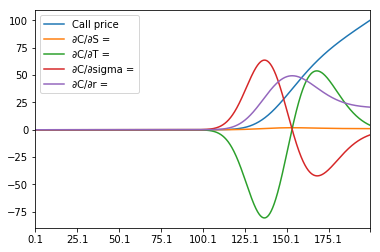

In [25]:

def MAIN_print_AAD_price_greeks():
    ###################################
    # 1 BS WITH REVERSE AUTODIFF
    res=[["S","Call price", "∂C/∂S =","∂C/∂T =","∂C/∂sigma =","∂C/∂r ="]]
    scale=10
    max_S=200
    for si in range(1,max_S*scale):
        S =Variable(si/scale)
        K=Variable(100)
        T=Variable(0.2)
        sigma=Variable(0.23)
        r=Variable(0.02)
        B=Variable(150)
        
        #Call=call_expression(S,K,T,sigma,r)
        Call=call_upin_barrier_expression(S,K,T,sigma,r,B)
        #Call=digital_call(S,K,T,sigma,r)
        Call.evaluate()
        Call.derive(1)

        res.append([si/scale, Call.value, S.partial, -T.partial, sigma.partial, r.partial])
    res=np.array(res)

    res=pd.DataFrame(res[1:,1:],index=res[1:,0],columns=res[0,1:])
    res=res.astype('float64')
    
    plt.figure(figsize=(16, 8), dpi=150)
    res.plot(subplots=False)
    plt.show()
MAIN_print_AAD_price_greeks()

Thanks to the following researchers that did absolutely fantastic work on the subject:  
David Dallaire, Sébastien Geeraert, Cristian Homescu, Charles-Albert Lehalle, Barak Pearlmutter, Olivier Pironneau, Adil Reghai 
